In [1]:
import numpy as np
import math
from matplotlib import pyplot as plt
from astropy.io import ascii
import scipy.constants as con
import scipy.stats as stat
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import scipy.signal as signal
from decimal import Decimal

data = np.genfromtxt('data_headers.dat')
time = data[:,0]
flux = data[:,1]
errf = data[:,2]


#column 1 = time [days]
#column 2 = flux [e-/s]
#column 3 = error on flux [e-/s]

#some information we know
mins = 1.0/(24.0*60.0)      # one minute [days]
Phst = 95.48*mins           # period of HST
dur = 166.484/86400.0       # duration of the eclipse [days]
t0 = 57531.91792371155      # midtime of first eclipse 
Ptran = 0.08437610463121233 # period of eclipse [days]
cadence = 13.2/86400.0      # cadence [days]

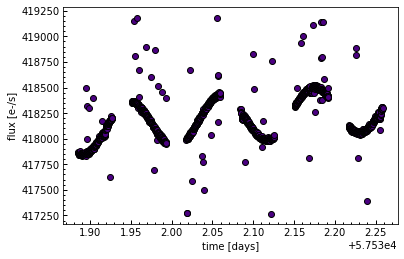

In [2]:
fig, ax = plt.subplots()
plt.errorbar(time, flux, errf,
             fmt='o', markerfacecolor='indigo', markeredgecolor='black', ecolor='black', capsize=2)
plt.xlabel('time [days]')
plt.ylabel('flux [e-/s]')

def setaxparams(): #axis formatting stuff
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(which='both', width=1, direction='in')
    ax.tick_params(which='major', length=4)
    ax.tick_params(which='minor', length=2, direction='in')
setaxparams()

params = {'mathtext.default': 'regular', 'font.family':'monospace'} #label formatting stuff
plt.rcParams.update(params)

plt.savefig('1.pdf')

<ErrorbarContainer object of 3 artists>

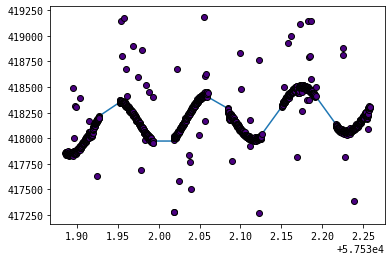

In [3]:
#TASK 1: REMOVE OUTLIERS

# Define a moving median function

def movingmedian(x, window):
    ii = 0
    mm = np.zeros(int(np.size(x) - window)+1)
    while ii + window <= np.size(x):
        mm[ii] = np.median(x[ii:ii+window])
        ii += 1
    return mm
#calculate moving medians
smoothwindow = 11
timesmooth = movingmedian(time, smoothwindow)
fluxsmooth = movingmedian(flux, smoothwindow)

# Append the edges of the windows
timesmooth_append = np.append(time[0:5], timesmooth)
timesmooth_append = np.append(timesmooth_append, time[-5:])
fluxsmooth_append = np.append(flux[0:5], fluxsmooth)
fluxsmooth_append = np.append(fluxsmooth_append, flux[-5:])

plt.plot(timesmooth_append, fluxsmooth_append)
plt.errorbar(time, flux, errf,
             fmt='o', markerfacecolor='indigo', markeredgecolor='black', ecolor='black', capsize=2)

Text(0.5, 1.0, 'Moving Median by Time')

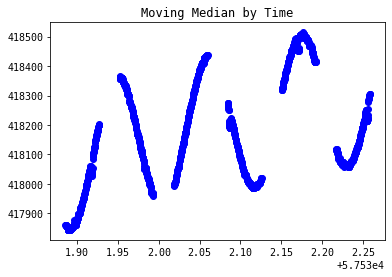

In [4]:
# Define a moving median function using time rather than index

def movingmedian_time(f, t, window):
    ii = 0
    mm = np.zeros(int(np.size(t)))
    while ii < np.size(t):
        interval = f[np.where(np.logical_and(-window/2 + t[ii] < t, t < window/2 + t[ii]))]
        mm[ii] = np.median(interval)
        #interval = [-window/2 + t[ii], window/2 + t[ii]]
        ii += 1
    return mm
#calculate moving medians
flux_mm = movingmedian_time(flux, time, 0.0015)

plt.scatter(time, flux_mm, color = 'b')
plt.title('Moving Median by Time')


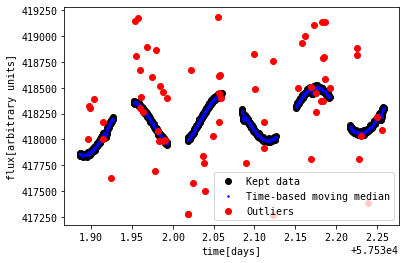

4.299065420560748  % of the original data is an outlier


In [5]:
# Split data into good vs. bad
sigmas = 3

data2 = data[np.abs(flux_mm - flux) < sigmas * errf]
baddata = data[np.abs(flux_mm - flux) > 3 * errf]
data2 = data2[2:,:]
baddata = baddata[2:,:]

%matplotlib inline

plt.scatter(data2[:,0], data2[:,1], color = 'k', label = 'Kept data')
plt.scatter(time,  flux_mm, s = 2, color = 'b', label = 'Time-based moving median')
plt.scatter(baddata[:,0], baddata[:,1], color = 'r', label = 'Outliers')
plt.xlabel('time[days]')
plt.ylabel('flux[arbitrary units]')
plt.legend()
plt.savefig('2.pdf')
plt.show()
print(100*len(baddata)/len(flux), ' % of the original data is an outlier')


In [6]:
time_2 = data2[:,0]       # Time [d]
flux_2 = data2[:,1]       # Flux [arbitrary units] 
fluxerr_2 = data2[:,2]    # Error on flux [arbitrary units]

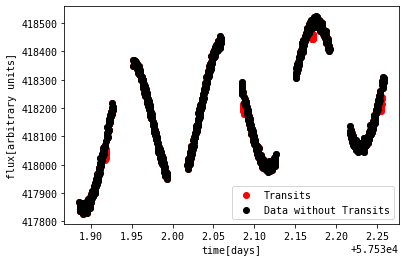

In [7]:
# Task 2: FIND THE SINUSOIDAL SIGNAL's PERIOD
# Task 2a: Remove the transits first, which could mess things up
time_2 = data2[:,0]       # Time [d]
flux_2 = data2[:,1]       # Flux [arbitrary units] 
fluxerr_2 = data2[:,2]    # Error on flux [arbitrary units]

duration = 166.484/86400
fct = 57531.91792371155
period = 2.025026511149096/24

central_times = fct + period*np.arange(50)
data_3 = np.copy(data2)
i = 0
while i < 50:
    data_3 = data_3[(~(np.logical_and(central_times[i] - duration/2 <= data_3[:,0], central_times[i] + duration/2 >= data_3[:,0])))]
    i+=1
    
%matplotlib inline
plt.scatter(time_2, flux_2, color = 'r', label = 'Transits')
plt.scatter(data_3[:,0], data_3[:,1], color = 'k', label = 'Data without Transits')
plt.legend()
plt.ylabel('flux[arbitrary units]')
plt.xlabel('time[days]')
plt.show
plt.savefig('3.pdf')

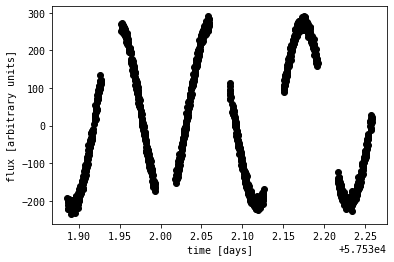

-34404219.41944991 605.2691887815108


In [8]:
#Task 2b: Remove a linear trend first, before passing through to periodogram
tempslope = np.polyfit(data_3[:,0], data_3[:,1],1)
periodogramdata = data_3[:,1] - (tempslope[1] + tempslope[0]*data_3[:,0])

%matplotlib inline
plt.scatter(data_3[:,0], periodogramdata, color = 'k')
plt.xlabel('time [days]')
plt.ylabel('flux [arbitrary units]')
plt.show()
print (tempslope[1], tempslope[0])

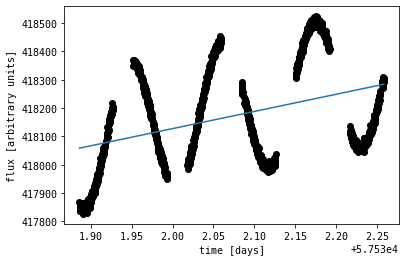

-34404219.41944991 605.2691887815108


In [9]:
#Plot of linear trend superimposed on not-yet-detrended data
%matplotlib inline
plt.scatter(data_3[:,0], data_3[:,1], color = 'k')
plt.plot(data_3[:,0], tempslope[1] + tempslope[0]*data_3[:,0])
plt.xlabel('time [days]')
plt.ylabel('flux [arbitrary units]')
plt.show()
print (tempslope[1], tempslope[0])

In [10]:
nfreq = 50000
freqmin = 2 * np.pi / (data_3[-1,0] - data_3[0,0])
freqmax = 1 * np.pi / (data_3[1,0] - data_3[0,0])
freqs = np.linspace(freqmin, freqmax, nfreq)
periods = 2 * np.pi/freqs
pgrm = signal.lombscargle(data_3[:,0], periodogramdata, freqs)
Pbest = periods[np.argmax(pgrm)]
#periodogram has a peak at (A**2)*N/4, according to scipy documentation, so
Abest = np.sqrt(4.0*pgrm[np.argmax(pgrm)]/len(data_3[:,0]))

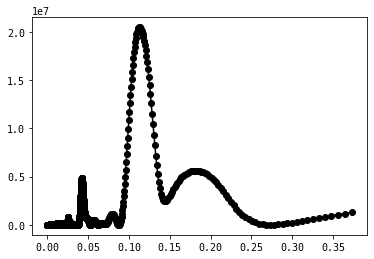

In [11]:
%matplotlib inline

plt.scatter(periods, pgrm, color = 'k')
plt.plot(periods, pgrm, color = 'k')

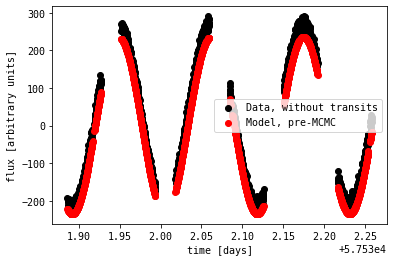

235.00351695807598

In [12]:
# TASK 3: REMOVE THE SINUSOID + TREND
# Task 3a: Start by plotting our vanilla sinusoid and manually tune the phase

fittedsinusoid = Abest*np.sin(2.0*np.pi*data_3[:,0]/Pbest - 1.0)

%matplotlib inline

plt.scatter(data_3[:,0], periodogramdata, color = 'k', label = 'Data, without transits')
plt.scatter(data_3[:,0], fittedsinusoid, color = 'r', label = 'Model, pre-MCMC')
plt.xlabel('time [days]')
plt.ylabel('flux [arbitrary units]')
plt.legend()
plt.savefig('4.pdf')
plt.show()
Abest


In [13]:
#TASK 3: REMOVE THE SINUSOID + A LINEAR TREND TOGETHER
#Use MCMC fitter written last time

time = data_3[:,0]       # Time [d]
flux = data_3[:,1]       # Flux [arbitrary units] 
fluxerr = data_3[:,2]    # Error on flux [arbitrary units]


#define model
def model(t, theta):
    modflux = theta[0] + theta[1]*t + theta[2]*np.sin(2.0*np.pi*t/theta[3] - theta[4])
    return modflux

#Set a definition for loglike, assuming normally distributed data
def log_like(t, f, ferr, theta):
    log_independent_terms = -0.5*(np.log(2*np.pi))*len(t)-np.sum(np.log(ferr))
    model_flux = model(t, theta)
    loglike = -0.5*np.sum(((model_flux - f)/ferr)**2) + log_independent_terms
    return loglike

In [14]:
#Set priors for mcmc from reasonable data
def log_prior(theta):
    # Prior for theta[0]: a1~logU[-34339900, -34339800]
    log_prior_0 = np.log(1/100)
    # Prior for theta[1]: a2~U[500,700]
    log_prior_1 = np.log(1/200)
    # Prior for theta[2]: A~U[210,250]
    log_prior_2 = np.log(1/40)
    # Prior for theta[3]: P ~ normal[0.11324553378582629, 0.2]
    log_prior_3 = np.log(np.exp(-0.5*((theta[3]- 0.11324553378582629)/0.2)**2)/(0.2*np.sqrt(2*np.pi)))
    # Prior for theta[4]: phi~U[-4,4]
    log_prior_4 = np.log(1/8)
    sum_prior = np.sum([log_prior_0, log_prior_1, log_prior_2, log_prior_3, log_prior_4])
    return sum_prior

#Set an initial chain point, seed from priors/prior results
theta_seed = np.zeros(5)
theta_seed[0] = -34339857.60256808
theta_seed[1] = 604.1504709407586
theta_seed[2] = 234.8121165311916
theta_seed[3] = 0.11324553378582629
theta_seed[4] = - 1.00

#theta_seed[0] = -34339860
#theta_seed[1] = 607
#theta_seed[2] = 236
#theta_seed[3] = 0.113
#theta_seed[4] = - 1.00

In [15]:
#Define proposal jump size
a0jump = 0.001*np.median(fluxerr)
a1jump = 0.001*np.median(fluxerr)/(np.amax(time) - np.amin(time))
Ajump = .001
Pjump = 0.00000001
phijump = 0.000001
thetajump = np.array([a0jump, a1jump, Ajump, Pjump, phijump])
print(np.random.normal(0, thetajump))
print (log_like(time, flux, fluxerr, theta_seed))

[1.61476335e-02 1.65094588e-02 2.06759650e-05 4.36930628e-09
 3.80555507e-07]
-723486.3550807012


In [16]:
def run_mcmc(theta_seed, jump_size, j_max):
    # Starting walking 
    j = 0
    theta_chain = np.copy(theta_seed)
    theta_0 = np.copy(theta_seed)
    log_like_0 = log_like(time, flux, fluxerr, theta_0)
    log_like_chain = np.copy(log_like_0)
    while True:
        #generate a proposal (or jump):
        log_like_0 = log_like(time, flux, fluxerr, theta_0)
        theta_prime = theta_0 + np.random.normal(0, jump_size)
        #Compute Metropolis Rule:
        log_like_prime = log_like(time, flux, fluxerr, theta_prime)
        log_like_delta = log_like_prime - log_like_0
        log_prior_delta = log_prior(theta_prime)-log_prior(theta_0)
        #probjump = np.minimum(1, np.exp(log_like_delta, dtype = np.float128))
        probjump = np.minimum(1, np.exp(log_like_delta + log_prior_delta, dtype = np.float128))
        if probjump >= np.random.uniform(0,1):
            # accept the jump
            j = j+1
            log_like_chain = np.append(log_like_chain, log_like_prime)
            theta_chain = np.vstack((theta_chain, theta_prime))
            theta_0 = theta_prime   
        else:
            j = j+1 #append failed trials
            log_like_chain = np.append(log_like_chain, log_like_0)
            theta_chain = np.vstack((theta_chain, theta_0))    
        if j == j_max:
            break
    return log_like_chain, theta_chain

In [17]:
# SHORT RUN
short_run = run_mcmc(theta_seed, thetajump, 100)
short_thetachain = short_run[1]

<ipython-input-16-9a8b74db2fa4>:17: RuntimeWarning: overflow encountered in exp
  probjump = np.minimum(1, np.exp(log_like_delta + log_prior_delta, dtype = np.float128))


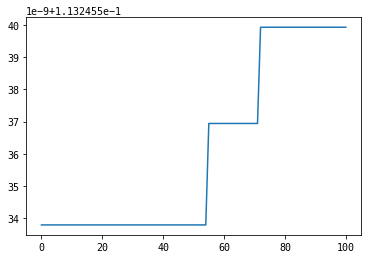

In [18]:
plt.plot(short_run[1][:, 3])

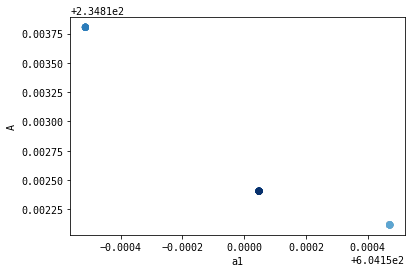

In [19]:
%matplotlib inline

jlist = np.arange(len(short_thetachain[:]))
plt.scatter(short_thetachain[:,1], short_thetachain[:,2], c = jlist, cmap = 'Blues')
plt.xlabel('a1')
plt.ylabel('A')
plt.show()

In [20]:
#MEDIUM RUN
#define new jump sizes
thetajump = np.std(short_thetachain, axis = 0)/20
medium_run = run_mcmc(short_thetachain[-1], thetajump, 900)
medium_theta_chain = medium_run[1]

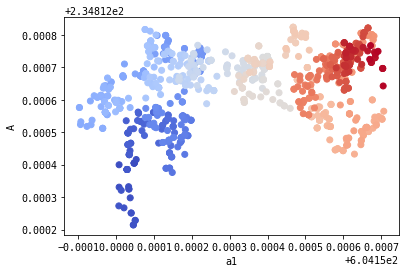

In [21]:
%matplotlib inline

jlist = np.arange(len(medium_theta_chain))
plt.scatter(medium_theta_chain[:,1], medium_theta_chain[:,2], c = jlist, cmap = 'coolwarm')
plt.xlabel('a1')
plt.ylabel('A')
plt.show()

In [22]:
#LONG RUN
#define new jump sizes
thetajump = np.std(short_thetachain, axis = 0)/20
long_run = run_mcmc(medium_theta_chain[-1], thetajump, 49000)
long_theta_chain = long_run[1]

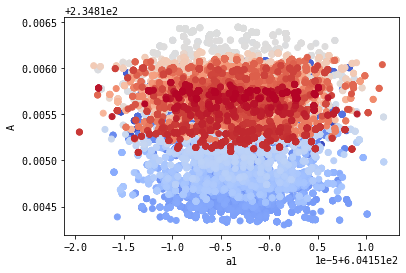

-5569.582750478925


In [23]:
%matplotlib inline

jlist = np.arange(len(long_theta_chain[10000:,0]))
plt.scatter(long_theta_chain[10000:,1], long_theta_chain[10000:,2], c = jlist, cmap = 'coolwarm')
plt.xlabel('a1')
plt.ylabel('A')
plt.show()

print(np.max(long_run[0]))

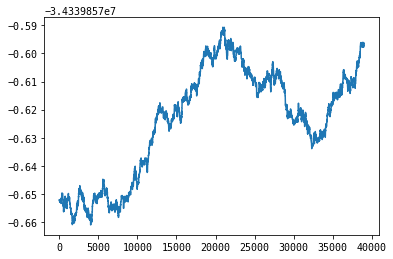

In [24]:
plt.plot(long_run[1][10000:, 0])

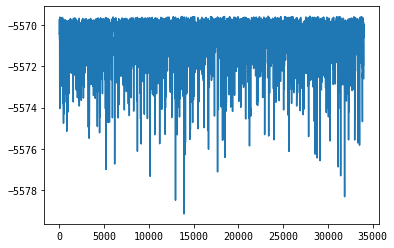

In [25]:
plt.plot(long_run[0][15000:])

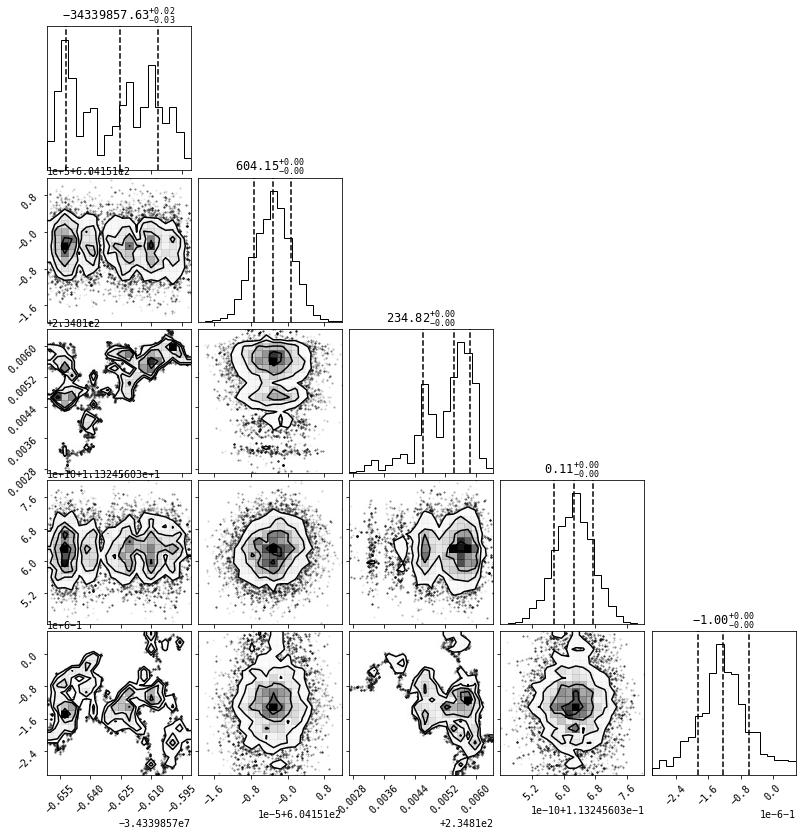

In [26]:
import corner #create corner plot to determine temperature, logfactor, and correlation
figure = corner.corner(long_theta_chain[1000:], quantiles = [.16, .5, .84], show_titles=True)

Dip size = 1.141E-2 ± 2.120E-3 %


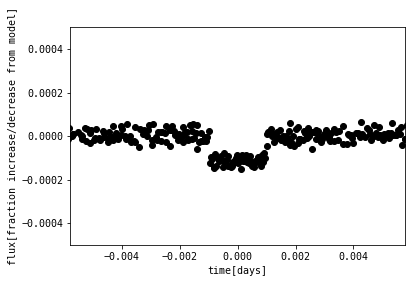

In [28]:
# TASK 4: CO-ADD TRANSITS TO GET DEPTH
from decimal import Decimal

de_trend = flux_2/model(time_2, theta_best) - 1
tfold = np.empty(len(time_2))
for i in range(len(time_2)):
    tfold[i] = time_2[i] - period*round((time_2[i] - fct)/period) - fct

dips = de_trend[np.where(np.logical_and(-duration/2 < tfold, tfold < duration/2))]
dip_spots = tfold[np.where(np.logical_and(-duration/2 < tfold, tfold < duration/2))]
dip_weights = fluxerr_2[np.where(np.logical_and(-duration/2 < tfold, tfold < duration/2))]
fluxerr_2_normalized = fluxerr_2/flux_2
dip_errors = fluxerr_2_normalized[np.where(np.logical_and(-duration/2 < tfold, tfold < duration/2))]


plt.scatter(dip_spots,dips, color = 'r' )

dip = -np.average(dips, weights = dip_weights)
dip_error = np.mean(dip_errors)
print(f'Dip size = {Decimal(dip*100):.3E} ± {Decimal(dip_error*100):.3E} %')

%matplotlib inline
plt.scatter(tfold, de_trend, color = 'k')
plt.axis([-3.0*duration, 3.0*duration, -0.0005, 0.0005])
plt.ylabel('flux[fraction increase/decrease from model]')
plt.xlabel('time[days]')
plt.savefig('6.pdf')
plt.show()

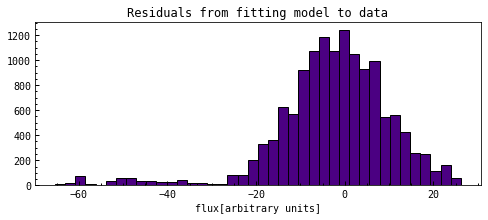

In [29]:
residuals = flux_2 - model(time_2, theta_best)

%matplotlib inline

fig, ax = plt.subplots(figsize=(8, 3))
setaxparams()
plt.hist(residuals, bins=40, weights = fluxerr_2, align='left', color='indigo', edgecolor='black',
              linewidth=1)
plt.title('Residuals from fitting model to data')
plt.xlabel('flux[arbitrary units]')
plt.show()

In [30]:
ct = np.copy(fct)
model_transits = np.copy(model(time_2, theta_best))
while ct < np.max(time_2):
    transit_points = np.where(np.logical_and(ct - duration/2 <= time_2, ct + duration/2 >= time_2))
    model_transits[transit_points] = model_transits[transit_points]*(1 - dip)
    ct += period
residuals_transits = flux_2 - model_transits

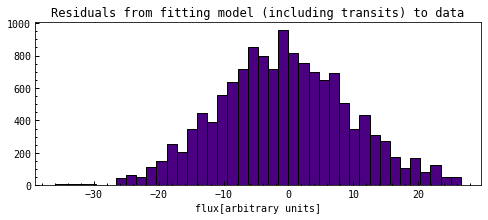

In [31]:
fig, ax = plt.subplots(figsize=(8, 3))
setaxparams()
plt.hist(residuals_transits, bins=40, weights = fluxerr_2, align='left', color='indigo', edgecolor='black',
              linewidth=1)
plt.title('Residuals from fitting model (including transits) to data')
plt.xlabel('flux[arbitrary units]')
plt.savefig('7.pdf')
plt.show()

In [32]:
#Constructing an MCMC for the transits, using depth as a single parameter given the values of the other parameters,
#found with the last MCMC

def model_transit(depth):
    ct = np.copy(fct)
    mt = np.copy(model(time_2, theta_best))
    while ct < np.max(time_2):
        transit_points = np.where(np.logical_and(ct - duration/2 <= time_2, ct + duration/2 >= time_2))
        mt[transit_points] = mt[transit_points]*(1 - depth)
        ct += period
    return mt

def log_like_transit(f, ferr, theta):
    log_independent_terms = -0.5*(np.log(2*np.pi))*len(time_2)-np.sum(np.log(ferr))
    model_flux = model_transit(theta)
    loglike = -0.5*np.sum(((model_flux - f)/ferr)**2) + log_independent_terms
    return loglike

def log_prior_transit(theta):
    # Prior for theta: P ~ normal[1.141E-4, 2.120E-5]
    log_prior = np.log(np.exp(-0.5*((theta - dip)/dip_error)**2)/(dip_error*np.sqrt(2*np.pi)))
    return log_prior

In [33]:
def run_mcmc_transit(theta_seed, jump_size, j_max):
    # Starting walking 
    j = 0
    theta_chain = np.copy(theta_seed)
    theta_0 = np.copy(theta_seed)
    log_like_0 = log_like_transit(flux_2, fluxerr_2, theta_0)
    log_like_chain = np.copy(log_like_0)
    while True:
        #generate a proposal (or jump):
        log_like_0 = log_like_transit(flux_2, fluxerr_2, theta_0)
        theta_prime = theta_0 + np.random.normal(0, jump_size)
        #Compute Metropolis Rule:
        log_like_prime = log_like_transit(flux_2, fluxerr_2, theta_prime)
        log_like_delta = log_like_prime - log_like_0
        log_prior_delta = log_prior_transit(theta_prime)-log_prior_transit(theta_0)
        #probjump = np.minimum(1, np.exp(log_like_delta, dtype = np.float128))
        probjump = np.minimum(1, np.exp(log_like_delta + log_prior_delta, dtype = np.float128))
        if probjump >= np.random.uniform(0,1):
            # accept the jump
            j = j+1
            log_like_chain = np.append(log_like_chain, log_like_prime)
            theta_chain = np.vstack((theta_chain, theta_prime))
            theta_0 = theta_prime   
        else:
            j = j+1 #append failed trials
            log_like_chain = np.append(log_like_chain, log_like_0)
            theta_chain = np.vstack((theta_chain, theta_0))    
        if j == j_max:
            break
    return log_like_chain, theta_chain

In [34]:
transit_jump = 10**(-6)
transit_mcmc = run_mcmc_transit(dip, transit_jump , 10000)

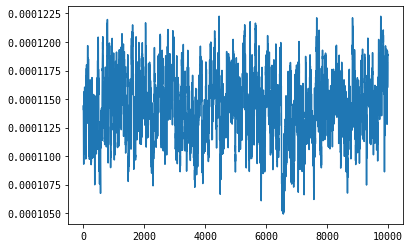

In [35]:
plt.plot(transit_mcmc[1])

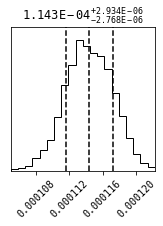

In [36]:
figure = corner.corner(transit_mcmc[1], quantiles = [.16, .5, .84], title_fmt=".3E", show_titles=True)
plt.savefig('8.pdf')


In [37]:
#RMS vs. Bin Size

binsizes = np.arange(1,100)
rms = []
bin_residuals = []
for b in binsizes:
    ii = 0
    while ii < len(residuals_transits):
        bin_residuals.append(np.median(residuals_transits[ii:ii+b]))
        ii += b
    rms.append(np.sqrt(np.mean(np.array(bin_residuals)**2)))

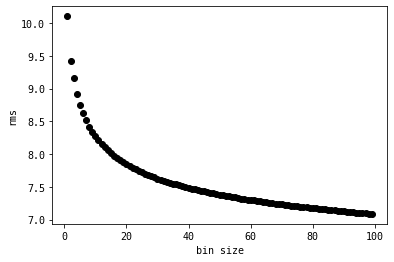

In [38]:
%matplotlib inline
plt.scatter(binsizes, rms, color='k') 
plt.xlabel('bin size')
plt.ylabel('rms')
plt.savefig('9.pdf')
plt.show()

## 